In [1]:
cd /Users/joepalmo/Desktop/cfa/SDU-preproc

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob


In [3]:
# specify path to the lightcurve and spectrum
lc_path = "FRB/FRB20210401A_flux.csv"
spec_path = "FRB/frb20201124a_host_binospec.txt"

# object name (or abbreviation)
n = "FRB"

# resample length for time-sorted LC purposes
resample_len = '1sec'

# Time Sorted Light Curve

In [4]:
#load into pandas dataframes
lc = pd.read_csv(lc_path)

In [5]:
lc

,# delta T(ms),flux(Jy)
0,-302.6160,1.3684
1,-301.4316,-0.4941
2,-300.2472,-0.1754
3,-299.0628,-0.1100
4,-297.8784,-0.0798
...,...,...
507,297.8784,-0.5495
508,299.0628,0.7301
509,300.2472,0.3369
510,301.4316,-0.2185


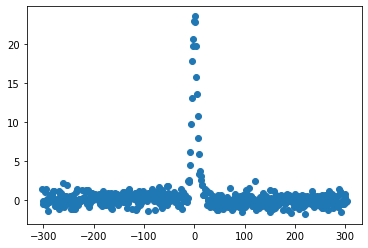

In [8]:
plt.scatter(lc['# delta T(ms)'], lc[' flux(Jy)'])

In [9]:
def format_df1(arr, bins, rephased):
    """
    Function used to format phased LC data into a pandas df that can be input into sonoUno. This means
    binning, averaging, and extending x-axis across 2 phases.
    """
    # bin by phase -> 100 points
    s, edges, _ = binned_statistic(arr[:,0],arr[:,1], statistic='mean', bins=bins)
    bincenters = edges[:-1]+np.diff(edges)/2
    
    #to df - name columns
    new_arr = np.vstack((bincenters, s)).T
    df = pd.DataFrame(new_arr, columns = ['Phase', 'Magnitude'])

    if rephased is True:
        rephase = df[df.Phase.between(0.505, 1.495)]['Magnitude'].to_numpy()
        rephase = np.append(rephase, rephase)
        rephase_arr = np.vstack((bincenters, rephase)).T
        rephase_df = pd.DataFrame(rephase_arr, columns=['Phase', 'Magnitude'])

        return rephase_df
    
    return df


In [10]:
log_arr = np.vstack((lc['# delta T(ms)'], lc[' flux(Jy)'])).T

In [27]:
logbins = np.arange(-100,100,1)

In [28]:
time_preproc_lc = format_df1(log_arr, logbins, False).rename(columns={'Phase':'delta T(ms)', 'Magnitude':'flux(Jy)'})

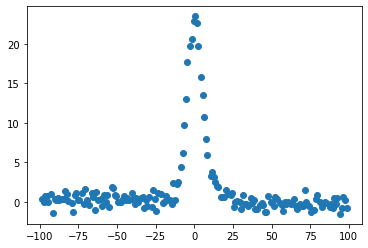

In [29]:
plt.scatter(time_preproc_lc['delta T(ms)'], time_preproc_lc['flux(Jy)'])

In [30]:
len(time_preproc_lc)

199

In [31]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 23.41176470588235 s


# Spectra

In [62]:
spec = pd.read_csv(spec_path, delimiter='\s+', skiprows=16, header=None)
spec.columns= ['wavelength', 'flux', 'fluxerr']

In [48]:
spec

,wavelength,flux,fluxerr
0,3827.47790,0.36295,0.81770
1,3828.76101,1.35330,0.83875
2,3830.04413,1.05379,0.83769
3,3831.32728,1.69807,0.84146
4,3832.61045,1.42518,0.81949
...,...,...,...
4063,9208.86978,6.72935,0.34809
4064,9210.21826,6.53057,0.34929
4065,9211.56347,7.11436,0.45445
4066,9211.57250,7.49558,0.59663


In [64]:
preproc_spec = spectra_preproc(spec, bins=np.arange(3820,9220,20))

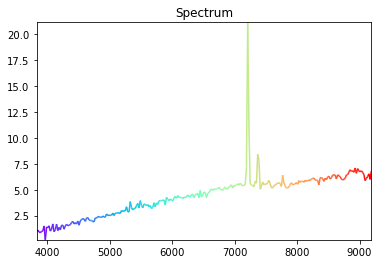

In [66]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [67]:
len(preproc_spec) / 8.5

31.647058823529413

# Save Preprocessed Files

In [68]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [69]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)